#Preliminary operations

##Import libraries

In [1]:
# import main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.dummy import DummyClassifier

In [2]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# stats
from scipy import stats
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# train, test, split
from sklearn.model_selection import train_test_split
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
# repeated stratified kfold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
# randomized and grid search cv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Dummy clf
from sklearn.dummy import DummyClassifier

##Mount Google Drive

In [4]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import datasets

In [5]:
# import dataframe (without outliers)
df = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_prep_final.xlsx", index_col="Unnamed: 0")
df_emph_high = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_prep_final_emph_high.xlsx", index_col="Unnamed: 0")
df_emph_low = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_prep_final_emph_low.xlsx", index_col="Unnamed: 0")

In [6]:
df.columns

Index(['vocal_channel', 'emotion', 'emotional_intensity', 'statement',
       'repetition', 'actor', 'sex', 'channels', 'length_ms', 'intensity',
       'zero_crossings_sum', 'mfcc_mean', 'mfcc_max', 'sc_mean', 'sc_std',
       'sc_min', 'sc_max', 'sc_kur', 'stft_mean', 'stft_std', 'stft_min',
       'stft_kur', 'mean', 'kur', 'skew', 'loudness', 'emotion_type'],
      dtype='object')

In [7]:
# get data columns
df_data = df.loc[:, "length_ms":"skew"]
df_data_emph_high = df_emph_high.loc[:, "length_ms":"skew"]
df_data_emph_low = df_emph_low.loc[:, "length_ms":"skew"]

# get values from data columns
X = df_data.values
X_emph_high = df_data_emph_high.values
X_emph_low = df_data_emph_low.values

# get emotion lables from each emphasis group
y_emotion = df["emotion"]
y_emotion_emph_high = df_emph_high["emotion"]
y_emotion_emph_low = df_emph_low["emotion"]

# get emotion type from each emphasis group
y_emtype = df["emotion_type"]
y_emtype_emph_high = df_emph_high["emotion_type"]
y_emtype_emph_low = df_emph_low["emotion_type"]

##Standardization

In [8]:
# get StandardScaler
std_scaler = StandardScaler()

# normalise each emphasis group with StandardScaler
X_std = std_scaler.fit_transform(X)
X_std_emph_high = std_scaler.fit_transform(X_emph_high)
X_std_emph_low = std_scaler.fit_transform(X_emph_low)

# get MinMaxScaler
mima_scaler = MinMaxScaler()

# normalise each emphasis group with MinMaxScaler
X_mima = mima_scaler.fit_transform(X)
X_mima_emph_high = mima_scaler.fit_transform(X_emph_high)
X_mima_emph_low = mima_scaler.fit_transform(X_emph_low)

## Partitioning for emotion

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
"""X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_emotion, 
    test_size=0.2, 
    random_state=0,
    stratify = y_emotion 
)"""

'X_train, X_test, y_train, y_test = train_test_split(\n    X, \n    y_emotion, \n    test_size=0.2, \n    random_state=0,\n    stratify = y_emotion \n)'

##Partitioning for emotion type ALL EMPHASIS


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emtype, 
    test_size=0.2, 
    random_state=0,
    stratify = y_emtype
)

In [12]:
X_train.min(), X_train.max(), X_test.min(), X_test.max()

(-61.06103874121523, 21832.0, -60.48176482250891, 21663.0)

COSE DA FARE PER LA CLASSIFICAZIONE (PER OGNI MODELLO):

Le cose che facciamo le facciamo per tutti e 3 i dataset (all emphasis, high emphasis e low emphasis). Facciamo la classificazione per le due variabili che abbiamo usato anche nel Clustering: "emotions" e "emotional_type" (strong, weak).

* Dividere in "training_set" (80%) e "test_set" (20%)
* Usare il "training_set" per fare la Cross_Validation stratificata (Stratified Cross Validation) in 10 parti per testare gli iperparametri, con Grid-Search se non va troppo lento; se va lento usiamo Randomized-Search.
* Testare la classificazione su tutte e due le variabili dette prima, per ognuno dei 3 dataset che abbiamo
* Misuarci tutte le metriche possibili e immaginabili che ha fatto vedere lo Spinnnato in laboratorio
* Fine, basta, boh. Bona cisi e se un cisi bona

Uso DummyClassifier, un classificatore che fa delle predizioni che ignorano le input features. This classifier serves as a simple baseline to compare against other more complex classifiers.

In [13]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_train, y_train))
print(dummy_clf.score(X_test, y_test))

0.5022947475777665
0.4969450101832994


In [14]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.metrics import classification_report

In [15]:
%%time
#GRID SEARCH
params = {
            'priors': [None],
            'var_smoothing': np.logspace(0,-9, num=100),
         }

gaussian_nb_grid = GridSearchCV(
    GaussianNB(), 
    param_grid=params, 
    n_jobs=-1, 
    cv=10, 
    verbose=5
)
gaussian_nb_grid.fit(X_train,y_train)

print('Best Accuracy Through Grid Search : {:.3f}'.format(gaussian_nb_grid.best_score_))
print('Best Parameters : {}\n'.format(gaussian_nb_grid.best_params_))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Accuracy Through Grid Search : 0.787
Best Parameters : {'priors': None, 'var_smoothing': 2.310129700083158e-09}

CPU times: user 330 ms, sys: 52.3 ms, total: 383 ms
Wall time: 5.51 s


In [16]:
clf = GaussianNB(priors= None, var_smoothing= 2.310129700083158e-09)

In [17]:
clf.fit(X_train, y_train)

GaussianNB(var_smoothing=2.310129700083158e-09)

In [18]:
print(clf.score(X_test, y_test))
y_pred = clf.predict(X_test)

0.7820773930753564


In [19]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

# plot_cumulative_gain and plot_lift_curve only work in a binary classification case

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      strong       0.85      0.79      0.82       303
        weak       0.69      0.78      0.73       188

    accuracy                           0.78       491
   macro avg       0.77      0.78      0.77       491
weighted avg       0.79      0.78      0.78       491



In [21]:
y_test_pred_proba = clf.predict_proba(X_test)

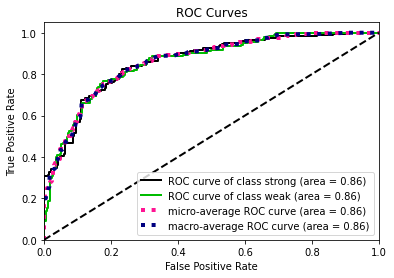

In [22]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()

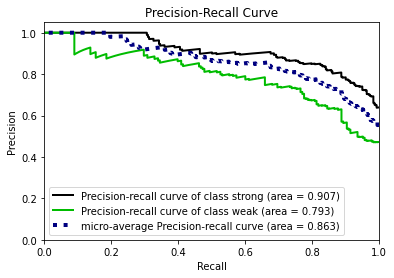

In [23]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()

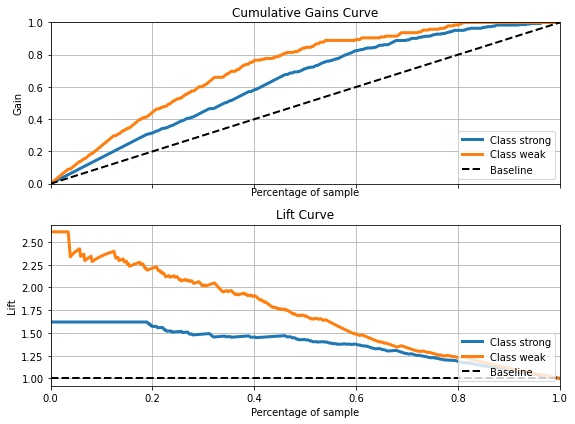

In [24]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,6))
plot_cumulative_gain(y_test, clf.predict_proba(X_test), ax=axs[0])
plot_lift_curve(y_test, clf.predict_proba(X_test), ax=axs[1])
plt.tight_layout()
plt.show()

#### Cross-validation

In [25]:
from sklearn.model_selection import cross_val_score

In [26]:
cross = np.array(cross_val_score(clf, X_train, y_train, cv=10))
print(cross)
print("media", np.mean(cross))
print("deviazione std.", np.std(cross))

[0.79187817 0.77040816 0.77040816 0.76020408 0.81122449 0.7755102
 0.80612245 0.81122449 0.78061224 0.79081633]
media 0.7868408784833731
deviazione std. 0.017374825884729675


In [27]:
# Dummy clf
from sklearn.dummy import DummyClassifier
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.4969450101832994


##ALTA ENFASI emotional type

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_emph_high,
    y_emtype_emph_high, 
    test_size=0.2, 
    random_state=0,
    stratify = y_emtype_emph_high
)

In [29]:
%%time
#GRID SEARCH
params = {
            'priors': [None],
            'var_smoothing': np.logspace(0,-9, num=100),
         }

gaussian_nb_grid = GridSearchCV(
    GaussianNB(), 
    param_grid=params, 
    n_jobs=-1, 
    cv=10, 
    verbose=5
)
gaussian_nb_grid.fit(X_train,y_train)

print('Best Accuracy Through Grid Search : {:.3f}'.format(gaussian_nb_grid.best_score_))
print('Best Parameters : {}\n'.format(gaussian_nb_grid.best_params_))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Accuracy Through Grid Search : 0.963
Best Parameters : {'priors': None, 'var_smoothing': 1.2328467394420635e-09}

CPU times: user 259 ms, sys: 20 ms, total: 279 ms
Wall time: 3.81 s


In [30]:
clf = GaussianNB(priors= None, var_smoothing= 1.2328467394420635e-09)

In [31]:
clf.fit(X_train, y_train)

GaussianNB(var_smoothing=1.2328467394420635e-09)

In [32]:
print(clf.score(X_test, y_test))
y_pred = clf.predict(X_test)

0.946969696969697


In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      strong       0.96      0.95      0.95       151
        weak       0.93      0.95      0.94       113

    accuracy                           0.95       264
   macro avg       0.95      0.95      0.95       264
weighted avg       0.95      0.95      0.95       264



In [34]:
y_test_pred_proba = clf.predict_proba(X_test)

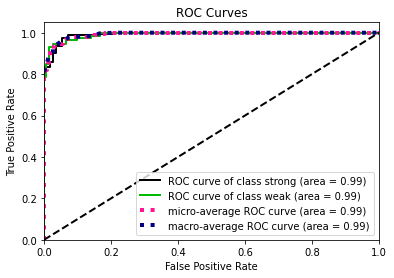

In [35]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()

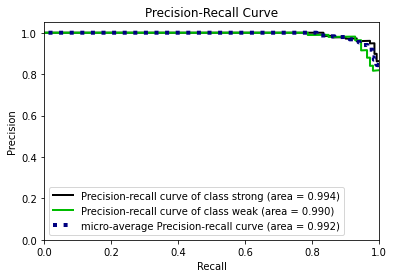

In [36]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()

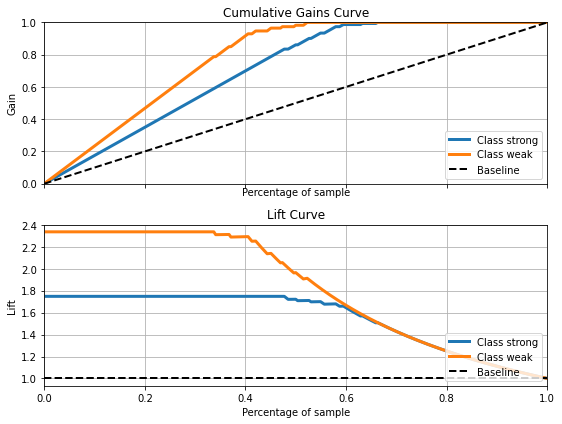

In [37]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,6))
plot_cumulative_gain(y_test, clf.predict_proba(X_test), ax=axs[0])
plot_lift_curve(y_test, clf.predict_proba(X_test), ax=axs[1])
plt.tight_layout()
plt.show()

#### Cross-validation

In [38]:
from sklearn.model_selection import cross_val_score

In [39]:
cross = np.array(cross_val_score(clf, X_train, y_train, cv=10))
print(cross)
print("media", np.mean(cross))
print("deviazione std.", np.std(cross))

[0.96226415 0.96226415 0.97169811 0.96226415 0.95238095 0.97142857
 0.93333333 0.95238095 0.98095238 0.98095238]
media 0.9629919137466307
deviazione std. 0.01377874151302051


In [40]:
# Dummy clf
from sklearn.dummy import DummyClassifier
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.5454545454545454


##LOW EMPHASIS emotional type

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_emph_low,
    y_emtype_emph_low, 
    test_size=0.2, 
    random_state=0,
    stratify = y_emtype_emph_low
)

In [42]:
%%time
#GRID SEARCH
params = {
            'priors': [None],
            'var_smoothing': np.logspace(0,-9, num=100),
         }

gaussian_nb_grid = GridSearchCV(
    GaussianNB(), 
    param_grid=params, 
    n_jobs=-1, 
    cv=10, 
    verbose=5
)
gaussian_nb_grid.fit(X_train,y_train)

print('Best Accuracy Through Grid Search : {:.3f}'.format(gaussian_nb_grid.best_score_))
print('Best Parameters : {}\n'.format(gaussian_nb_grid.best_params_))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Accuracy Through Grid Search : 0.756
Best Parameters : {'priors': None, 'var_smoothing': 0.01873817422860384}

CPU times: user 251 ms, sys: 14.8 ms, total: 265 ms
Wall time: 3.35 s


In [43]:
clf = GaussianNB(priors= None, var_smoothing= 0.01873817422860384)

In [44]:
clf.fit(X_train, y_train)

GaussianNB(var_smoothing=0.01873817422860384)

In [45]:
print(clf.score(X_test, y_test))
y_pred = clf.predict(X_test)

0.7180616740088106


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      strong       0.78      0.82      0.79       152
        weak       0.58      0.52      0.55        75

    accuracy                           0.72       227
   macro avg       0.68      0.67      0.67       227
weighted avg       0.71      0.72      0.71       227



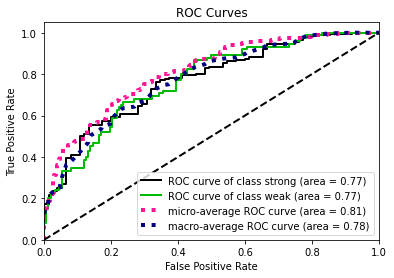

In [47]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()

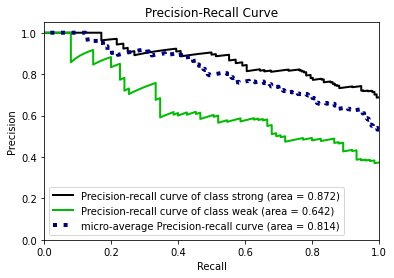

In [48]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()

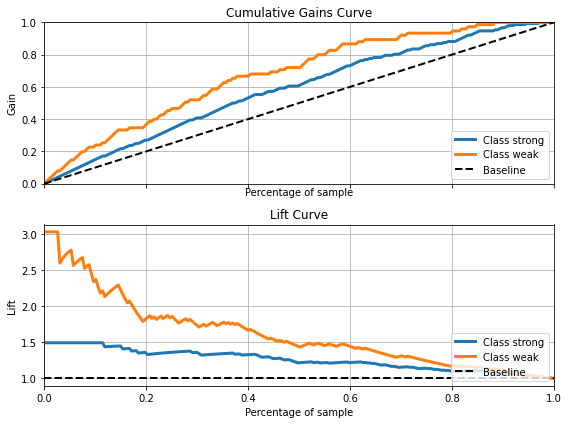

In [49]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,6))
plot_cumulative_gain(y_test, clf.predict_proba(X_test), ax=axs[0])
plot_lift_curve(y_test, clf.predict_proba(X_test), ax=axs[1])
plt.tight_layout()
plt.show()

#### Cross-validation

In [50]:
from sklearn.model_selection import cross_val_score

In [51]:
cross = np.array(cross_val_score(clf, X_train, y_train, cv=10))
print(cross)
print("media", np.mean(cross))
print("deviazione std.", np.std(cross))

[0.7032967  0.74725275 0.74725275 0.73626374 0.8021978  0.73626374
 0.75824176 0.77777778 0.73333333 0.82222222]
media 0.7564102564102564
deviazione std. 0.03349734013417288


In [52]:
# Dummy clf
from sklearn.dummy import DummyClassifier
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.5726872246696035
